In [3]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt, cm as cm, mlab as mlab
import matplotlib
from sklearn.preprocessing import StandardScaler
import seaborn as sns; sns.set()
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict
%run turchin.py

In [4]:
# read csv/excel data files 
pnas_data1 = pd.read_csv('/home/jaeweon/research/data/pnas_data1.csv')
pnas_data2 = pd.read_csv('/home/jaeweon/research/data/pnas_data2.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
def svd(data):
    """
    perform singular value decomposition on the given data matrix
    """
    #center the data
    mean = np.mean(data, axis=0)
    data -= mean
    
    P, D, Q = np.linalg.svd(data, full_matrices=False)
    
    return P, D, Q

In [17]:
# format data 

# extract 9 Complexity Characteristic variables 
features = ['PolPop', 'PolTerr', 'CapPop', 'levels', 'government','infrastr', 'writing', 'texts', 'money']

# take subset of original data table with 9 CCs and change it into numpy array 
data_mat = pnas_data1.loc[:, features].values
scaled = StandardScaler().fit_transform(data_mat)
P, D, Q = svd(scaled)
data = np.matmul(scaled, Q.T) # data matrix is obtained by multiplying initial data matrix with rotation matrix
ngas = pnas_data1.NGA.unique().tolist() # list of unique NGAs from the dataset


# The following histograms are projections of 9-d data vectors (original imputed data points) onto the main principal component, for each of the 20 imputed sets 

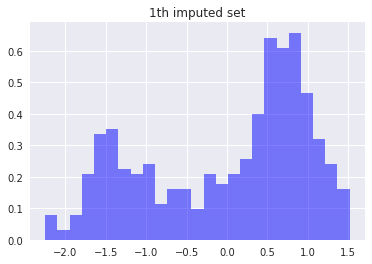

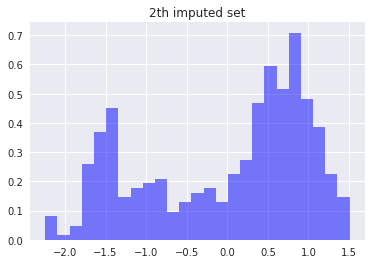

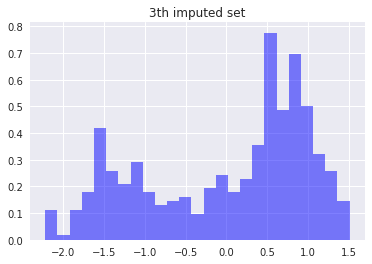

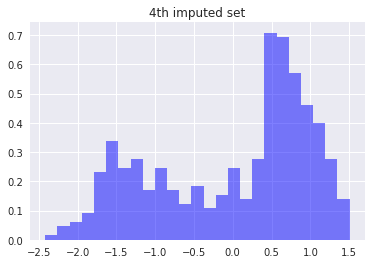

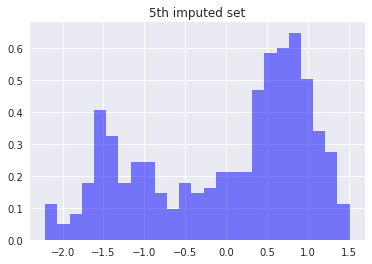

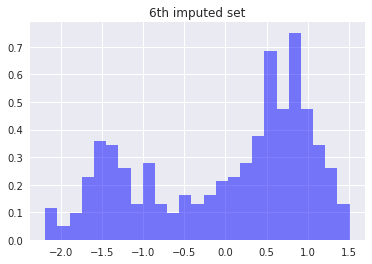

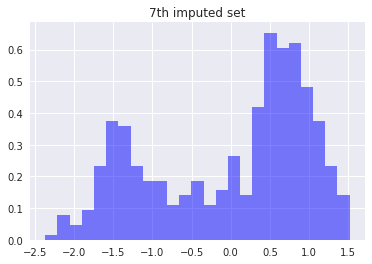

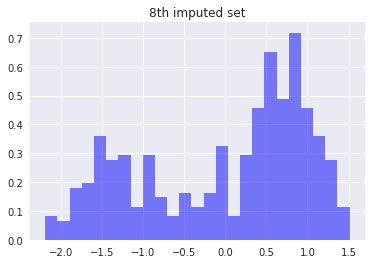

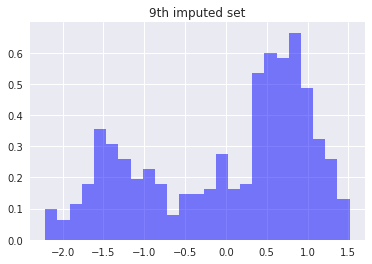

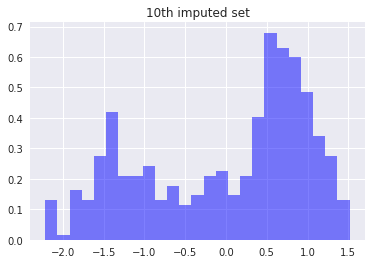

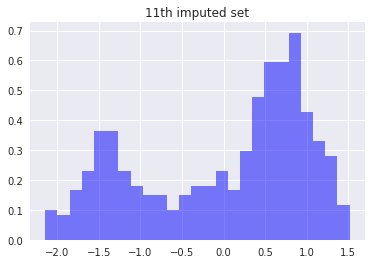

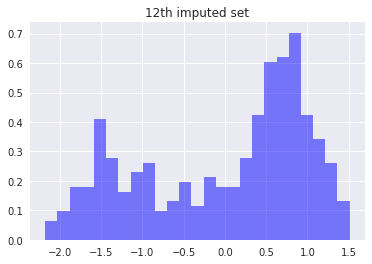

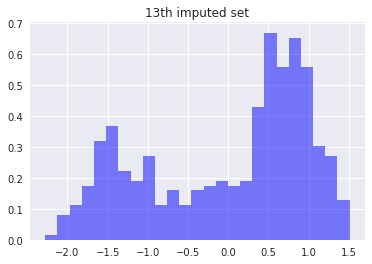

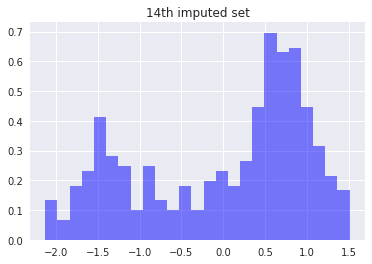

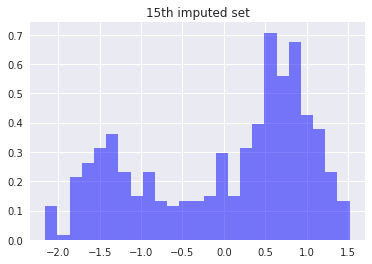

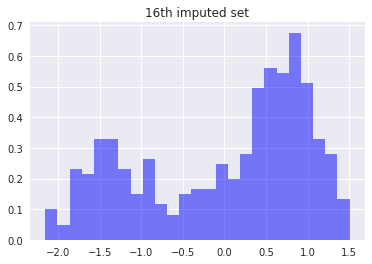

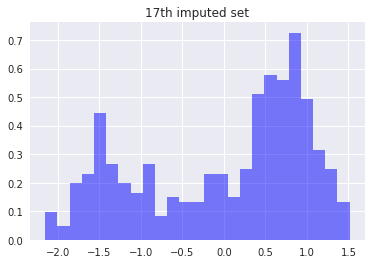

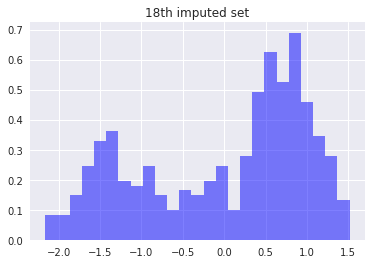

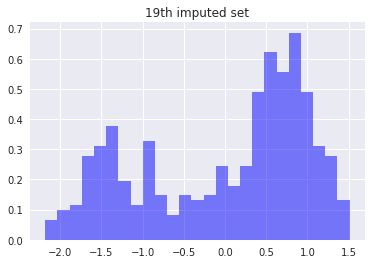

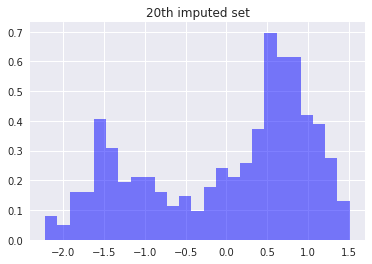

In [21]:
# histogram after projecting 9-d vectors into the main principal component, for each of the 20 imputed sets
impute = ['V'+str(i) for i in range(1, 21)]

for i in range(len(impute)):
    data2 = StandardScaler().fit_transform(pnas_data2.loc[:, [impute[i]]].values)
    # filtered_pnas1 = pnas_data1.loc[:, features].values
    num_bins = 25

    # the histogram/gaussian mixture model of the data
    n, bins, patches = plt.hist(data2, num_bins, normed=1, facecolor='blue', alpha=0.5)
    
    plt.title(str(i+1)+"th imputed set")
    plt.legend()
    plt.show()
    plt.close()

# The following histograms are projections of 9-d data vectors (original imputed data points) onto each of the 9 princpal components, using 20 imputed sets combined 

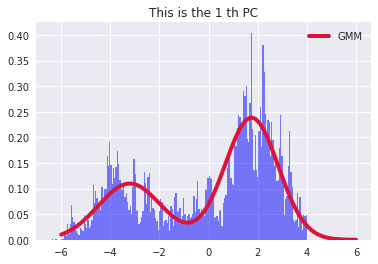

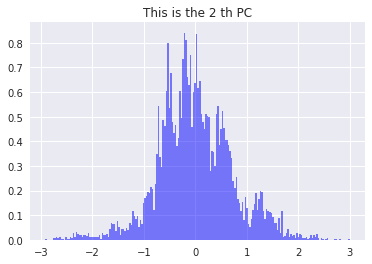

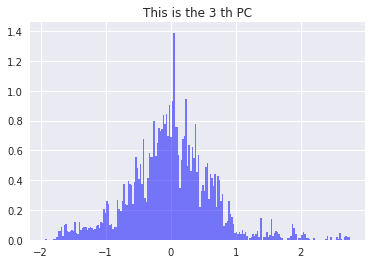

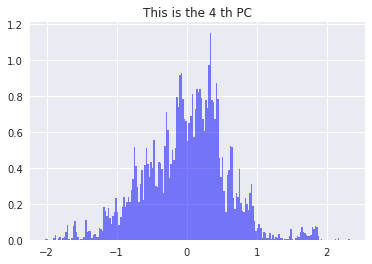

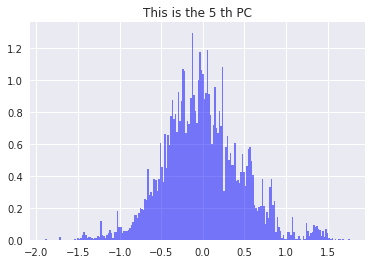

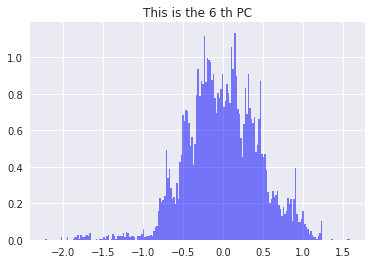

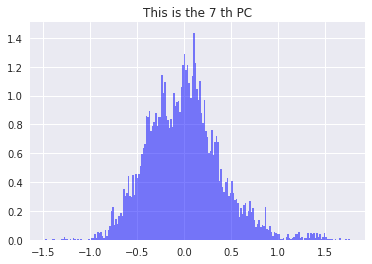

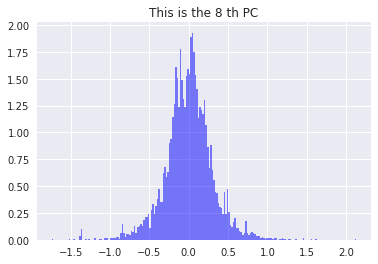

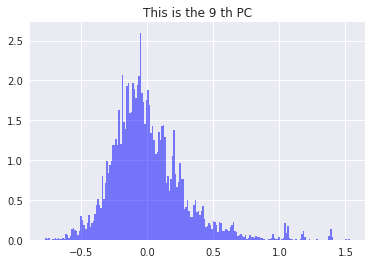

In [22]:
# histogram after projecting 9-d vectors into each of the 9 principal components, for 20 imputed sets combined

num_bins = 200
mu = 0 # mean (data is centered)

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# Evaluate GMM
gmm_x = np.linspace(-6, 6, 200)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

# the histogram/gaussian mixture model of the data for each of the principal component
for i in range(9):
    if i == 0:
        fig, ax = plt.subplots()
        ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")

    n, bins, patches = plt.hist(data[:,i], num_bins, normed=1, facecolor='blue', alpha=0.5)

    plt.title('This is the %s th PC'% str(int(i)+1))
    plt.legend()
    plt.show()
    plt.close()

# The following histograms are for each of the 9 Complexity Characteristic variables, using their original imputed values 

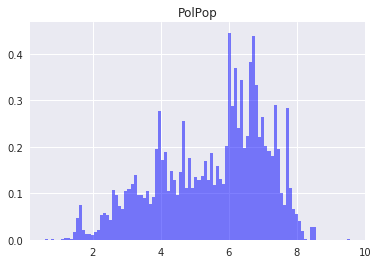

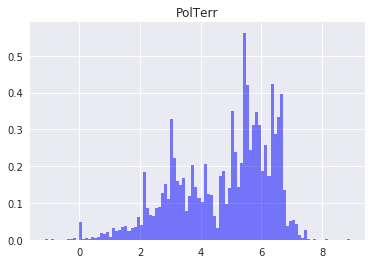

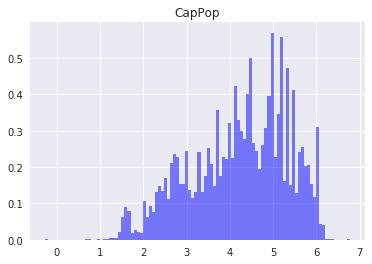

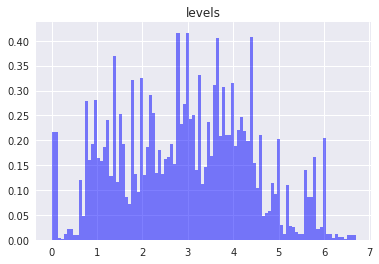

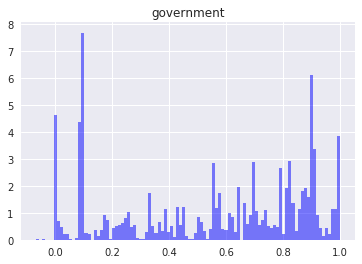

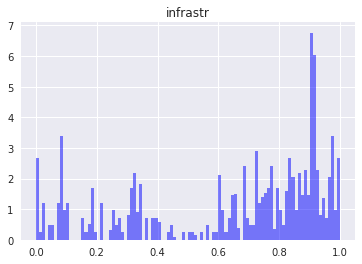

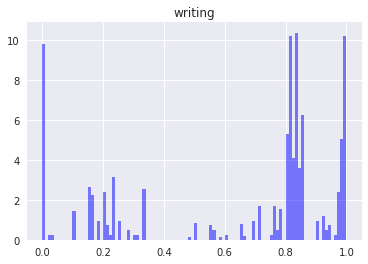

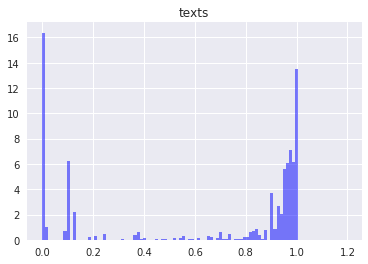

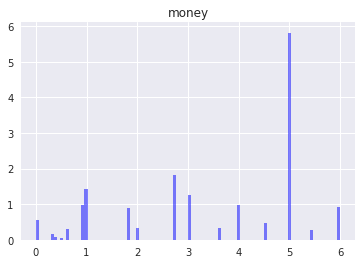

In [23]:
# histogram for each CCs (raw values)

num_bins = 100

for cc in range(9): 
    n, bins, patches = plt.hist(data_mat[:, cc], num_bins, normed=1, facecolor='blue', alpha=0.5)
    plt.title(features[cc])
    plt.legend()
    plt.show()
    plt.close()

# The following histogram is plotted using only the NGAs that span both Gaussians (20 out of 30 NGAs total)

[array([ -3.50439201e+00,  -4.04738981e+00,  -3.76936043e+00,
        -4.17849426e+00,  -3.93574413e+00,  -1.11158660e+00,
        -3.56151587e+00,  -2.54123769e+00,  -1.10182372e-01,
         1.82160373e-02,  -3.40383699e+00,  -3.95650579e+00,
        -3.73486702e+00,  -3.11287206e+00,   1.74983778e+00,
         1.75208185e+00,   1.76127560e+00,   1.77426208e+00,
         1.89176643e+00,   1.38409149e+00,   2.26746588e+00,
         2.31053822e+00,   1.93927843e+00,   1.94212769e+00,
         2.40615231e+00,   1.97232645e+00,   6.10644528e-01,
         2.26875864e+00,   2.33379006e+00,   2.39691315e+00,
        -3.94242279e+00,  -7.27174441e-01,  -1.89794300e+00,
         2.31762791e-01,  -2.60044819e+00,  -1.93597654e+00,
        -1.25983881e+00,  -5.90460426e-01,  -4.35922617e+00,
        -4.53895541e+00,  -3.43773792e+00,  -3.74161415e+00,
         4.51373784e-01,  -3.20058120e+00,  -2.40810207e+00,
         2.41371518e+00,   1.77136486e+00,   1.20392165e+00,
         1.36367736e+00

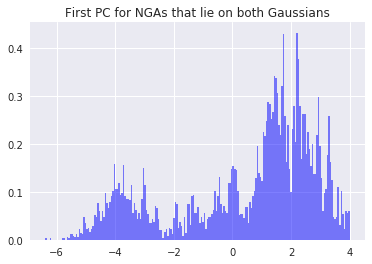

In [11]:
# histogram for NGAs that span both Gaussians

#fit GMM
gmm = GMM(n_components=2)
gmm = gmm.fit(X=np.expand_dims(data[:,0], 1))

# mean and covariance for each component
gauss_one = gmm.weights_[0] #weight for gaussian distribution
gauss_two = gmm.weights_[1] #weight for gaussian distribution 

idx_data = sorted(range(len(data[:,0])), key = lambda i: data[:,0][i]) #sort data points by their values on principal axis
prob_distr = gmm.predict_proba(X=np.expand_dims(sorted(data[:,0]), 1)) #probability distribution for gaussians on principal axis
lower = list()
higher = list()

for idx in range(len(prob_distr)):
    if gmm.weights_[0] < gmm.weights_[1]:
        if prob_distr[idx][0] >= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])
    else:
        if prob_distr[idx][0] <= prob_distr[idx][1]:
            lower.append(idx_data[idx])
        else:
            higher.append(idx_data[idx])

both_ngas = list()
# return polities that lie in both Gaussians for each imputed set
for i in range(1,21):
    impute = pnas_data1[pnas_data1.irep == i]
    lower_df = impute.loc[lower].dropna()
    higher_df = impute.loc[higher].dropna()

    unique_nga = [j for j in impute.NGA.unique().tolist() if (j in lower_df.NGA.unique().tolist()
                                                         and j in higher_df.NGA.unique().tolist())]
    nga_gauss = impute.loc[pnas_data1['NGA'].isin(unique_nga)]
    both_gauss = np.take(data[:,0], nga_gauss.index.values)
    both_ngas.append(both_gauss)

for i in range(len(both_ngas)-1):
    ngas = np.concatenate((both_ngas[i], both_ngas[i+1]), axis=0)
    both_ngas[i+1] = ngas
    
num_bins = 200
n, bins, patches = plt.hist(ngas, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('First PC for NGAs that lie on both Gaussians')
plt.legend()
plt.show()
plt.close()


# The following histogram is obtained after interpolating all the missing time periods within each NGA. This was done to experiment with the bimodality of the projected data (onto the main PC) and to address the potential undersampling issues 

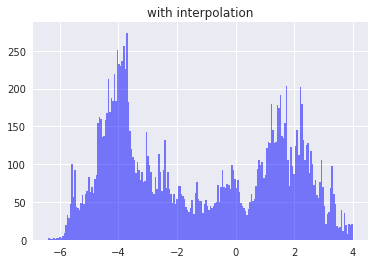

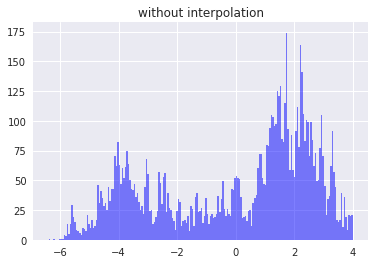

In [24]:
# linear interpolation of missing time periods 
added_rows = list()
for impute_step in range(1, 21):
    # interpolation for each imputation
    unique_region = pnas_data1.NGA.unique().tolist()
    
    for nga in unique_region:
        times = sorted(pnas_data1[pnas_data1.NGA == nga].Time.unique().tolist())
        if len(times) != ((max(times) - min(times))/100)+1:
            for time in range(len(times)-1):
                if times[time+1] - times[time] != 100:
                    
                    idx_val1 = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                               (pnas_data1.Time == times[time])].tolist()[0]
                    idx_val2 = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                               (pnas_data1.Time == times[time+1])].tolist()[0]
                    
                    diff = [i-j for i,j in zip(scaled[idx_val2], scaled[idx_val1])]
                    
                    num_steps = int((times[time+1]-times[time])/100)
                    
                    # linear interpolation
                    for i in range(1, num_steps):
                        diff_step = [(i/num_steps)*j for j in diff]
                        interpol = [k+l for k, l in zip(diff_step, scaled[idx_val1])]
                        
                        # check the validity of interpolation
                        for idx in range(len(interpol)):
                            assert ((interpol[idx] >= scaled[idx_val1, idx] and interpol[idx] < scaled[idx_val2, idx]) or
                                    (interpol[idx] < scaled[idx_val1, idx] and interpol[idx] >= scaled[idx_val2, idx]) or
                                    (interpol[idx] == scaled[idx_val1, idx] and interpol[idx] == scaled[idx_val2, idx]))
                            
                        added_rows.append(interpol)
                            
added_rows = np.asarray(added_rows)

assert added_rows.shape[1] == data_mat.shape[1]

data_matrix = np.vstack((scaled, added_rows)) # add interpolated rows to the original data matrix
proj = np.matmul(data_matrix, Q.T[:,0]) # project interpolated rows (as well as the original data) on principal axis
num_bins = 200

n, bins, patches = plt.hist(proj, num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('with interpolation')
plt.show()
plt.close()

n, bins, patches = plt.hist(data[:,0], num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('without interpolation')
plt.show()
plt.close()

# The following histograms are identical as above. Since interpolations for above histograms were done on the original 9-d vectors, I did interpolation on the projected PC values (1-d values) to confirm the above result. 

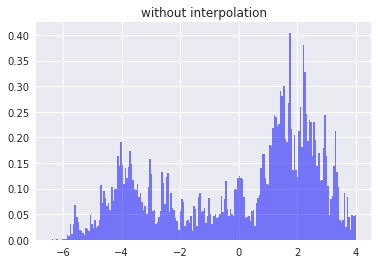

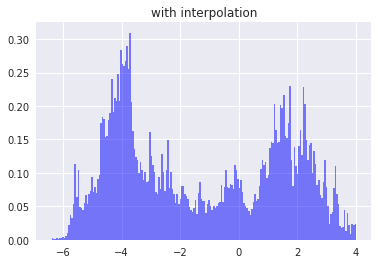

In [27]:
# check the above 9-d interpolation by doing interpolation on 1-d principal axis
num_bins = 200

n, bins, patches = plt.hist(data[:,0], num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('without interpolation')
plt.show()
plt.close()

# interpolating on the 1-d principal axis
period = [pnas_data1.loc[i]['Time'] for i in range(len(data[:,0]))]
added_rows = list()

for impute_step in range(1, 21):
    # 1) polity-based interpolation
    impute_set = pnas_data1[pnas_data1.irep==impute_step]
    unique_region = impute_set.NGA.unique().tolist()
    

    for nga in unique_region:
        times = sorted(impute_set[impute_set.NGA == nga].Time.unique().tolist())
        if len(times) != ((max(times)-min(times))/100)+1:
            for time in range(len(times)-1):
                if times[time+1]-times[time] != 100:
                    # linear interpolation
                    val1_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time]) &
                                                (pnas_data1['irep'] == impute_step)].tolist()[0]
                    val2_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time+1]) &
                                               (pnas_data1['irep'] == impute_step)].tolist()[0]

                    diff = data[:,0][val2_idx] - data[:,0][val1_idx]
                    
                    num_steps = int((times[time+1]-times[time])/100)

                    for i in range(1, num_steps):
                        diff_step = (i/num_steps)*diff
                        interpol = diff_step+data[:,0][val1_idx]
                        added_rows.append(interpol)
                        period.append(times[time]+100*i)

added_rows = np.asarray(added_rows)

pc_proj = np.concatenate((data[:,0], added_rows))

assert len(pc_proj) == len(period) 

n, bins, patches = plt.hist(pc_proj, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.title('with interpolation')
plt.show()
plt.close()



# Scatter plot for the interpolated data using time and principal component values as axes

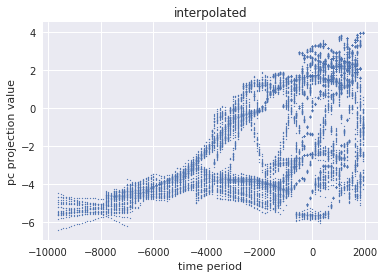

In [28]:
# scatter plot for interpolated data points
plt.scatter(period, pc_proj, s=1)
plt.title('interpolated')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()

# Scatter plot for the original data using time and principal component values as axes 

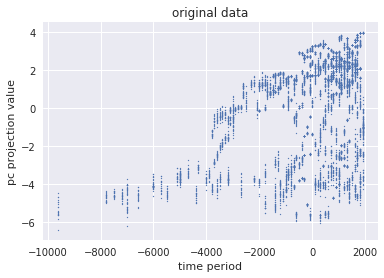

In [26]:
# scatter plot for original data points projected on the PC
orig_period = [pnas_data1.loc[i]['Time'] for i in range(len(data[:,0]))]
plt.scatter(orig_period, data[:,0], s=1)
plt.title('original data')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()

# Scatter plot for the interpolated data using time and principal component values as axes. Different NGAs are colored differently

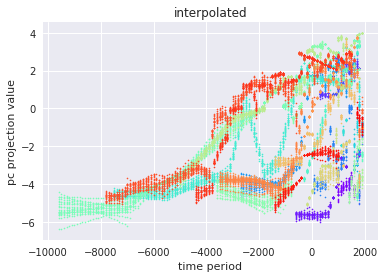

In [194]:
#9-d interpolation and scatter plot by NGAs

# interpolating on the 1-d principal axis
nga_interpolated = defaultdict(list)

for impute_step in range(1, 21):
    # 1) polity-based interpolation
    impute_set = pnas_data1[pnas_data1.irep==impute_step]
    unique_region = impute_set.NGA.unique().tolist()

    for nga in unique_region:
        times = sorted(impute_set[impute_set.NGA == nga].Time.unique().tolist())
        data_idx = list()
        for t in times: 
            data_idx.append(pnas_data1.index[(pnas_data1['NGA'] == nga) &
                                             (pnas_data1['Time'] == t) &
                                             (pnas_data1['irep'] == impute_step)].tolist()[0])
        nga_interpolated[nga].extend([(data[:,0][idx], time) for idx, time in zip(data_idx, times)])
        
        if len(times) != ((max(times)-min(times))/100)+1:
            for time in range(len(times)-1):
                if times[time+1]-times[time] != 100:
                    # linear interpolation
                    val1_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time]) &
                                                (pnas_data1['irep'] == impute_step)].tolist()[0]
                    val2_idx = pnas_data1.index[(pnas_data1['NGA'] == nga) & 
                                                (pnas_data1['Time'] == times[time+1]) &
                                               (pnas_data1['irep'] == impute_step)].tolist()[0]

                    diff = data[:,0][val2_idx] - data[:,0][val1_idx]
                    
                    num_steps = int((times[time+1]-times[time])/100)

                    for i in range(1, num_steps):
                        diff_step = (i/num_steps)*diff
                        interpol = diff_step+data[:,0][val1_idx]
                        nga_interpolated[nga].append((interpol, times[time]+100*i))
    
ngas = pnas_data1.NGA.unique().tolist()
colors = iter(cm.rainbow(np.linspace(0, 1, len(ngas))))
for nga in ngas:
    period = [time for val, time in nga_interpolated[nga]]
    pc_proj = [val for val, time in nga_interpolated[nga]]
    plt.scatter(period, pc_proj, s=1.5, color=next(colors))
plt.title('interpolated')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()

# Scatter plot for the interpolated data using time and principal component values as axes. For visibility, each plot contains 10 NGAs, each of which is marked by different color. 

['Big Island Hawaii', 'Cahokia', 'Cambodian Basin', 'Central Java', 'Chuuk Islands', 'Cuzco', 'Deccan', 'Finger Lakes', 'Garo Hills', 'Ghanaian Coast']


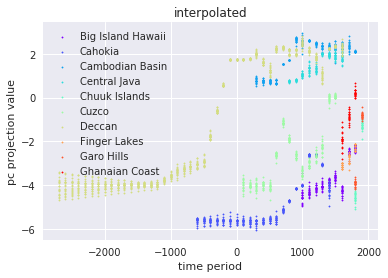

['Iceland', 'Kachi Plain', 'Kansai', 'Kapuasi Basin', 'Konya Plain', 'Latium', 'Lena River Valley', 'Lowland Andes', 'Middle Yellow River Valley', 'Niger Inland Delta']


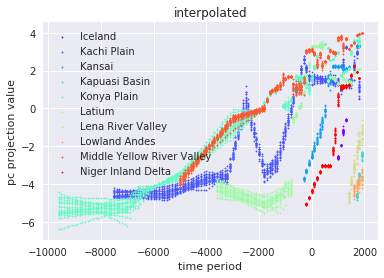

['North Colombia', 'Orkhon Valley', 'Oro PNG', 'Paris Basin', 'Sogdiana', 'Southern China Hills', 'Susiana', 'Upper Egypt', 'Valley of Oaxaca', 'Yemeni Coastal Plain']


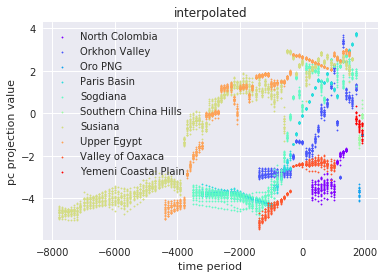

In [198]:
# colored plot for interpolated data separated by 10 arbitrarily chosen NGAs

for i in range(3):
    nga_split = ngas[10*i:10*i+10]
    print(nga_split)
    colors = iter(cm.rainbow(np.linspace(0, 1, len(nga_split))))
    for nga in nga_split:
        period = [time for val, time in nga_interpolated[nga]]
        pc_proj = [val for val, time in nga_interpolated[nga]]
        plt.scatter(period, pc_proj, s=2, color=next(colors))
    plt.legend(nga_split)
    plt.title('interpolated')
    plt.xlabel('time period')
    plt.ylabel('pc projection value')
    plt.show()
    plt.close()


# Time-weighted histogram. Data points that were time-wise more sparsely located were given more weights. Another attempt to address the undersampling issue and to check if bimodality survives. 

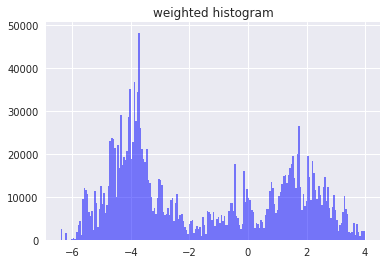

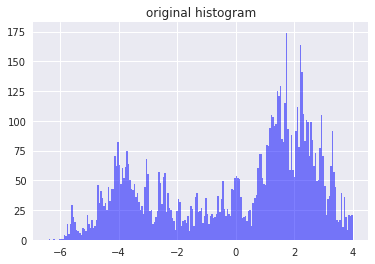

In [54]:
# compute the average temporal gap size for each data point (with respect to regions)
temporal_gap = dict()
weighted = list()
unique_region = pnas_data1.NGA.unique().tolist()
period = list()

for impute_step in range(1, 21):
    for nga in unique_region:
        times = sorted(pnas_data1[pnas_data1.NGA == nga].Time.unique().tolist())
        for time in range(len(times)):
            idx = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                    (pnas_data1.Time == times[time])].tolist()[0]
            if time == 0: # the data point is the first appearance of a polity in the nga
                temporal_gap[idx] = int(round((times[time+1]-times[time])))
            elif time == len(times)-1: # the data point is the last time period of the recorded nga
                temporal_gap[idx] = int(round((times[time] - times[time-1])))
            else: 
                temporal_gap[idx] = int(round((-times[time-1]+times[time+1])/2))

assert len(temporal_gap.keys()) == 8280 # temporal_gap must contain all 8280 points

# wegiht the occurence of each data point by their respective temporal gap size
for i in range(len(data[:,0])):
    weighted.extend(temporal_gap[i]*[data[:,0][i]])
    
num_bins = 200
n, bins, patches = plt.hist(weighted, num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('time weighted histogram')
plt.show()
plt.close()

n, bins, patches = plt.hist(data[:,0], num_bins, normed=False, facecolor='blue', alpha=0.5)

plt.title('original histogram')
plt.show()
plt.close()


# Scatter plot for the time weighted data using time and principal component values as axes

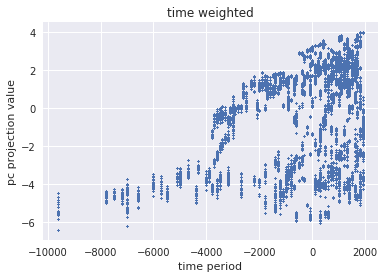

In [55]:
# 2d scatter plots for original data, interpolated data, and time weighted data with 
# positions along PC and date as two axes 

# compute the average temporal gap size for each data point (with respect to regions)
temporal_gap = dict()
weighted = list()
period = list()
unique_region = pnas_data1.NGA.unique().tolist()

for impute_step in range(1, 21):
    for nga in unique_region:
        times = sorted(pnas_data1[pnas_data1.NGA == nga].Time.unique().tolist())
        for time in range(len(times)):
            idx = pnas_data1.index[(pnas_data1.irep == impute_step) & (pnas_data1.NGA == nga) & 
                                    (pnas_data1.Time == times[time])].tolist()[0]
            if time == 0: # the data point is the first appearance of a polity in the nga
                temporal_gap[idx] = int(round((times[time+1]-times[time])))
            elif time == len(times)-1: # the data point is the last time period of the recorded nga
                temporal_gap[idx] = int(round((times[time] - times[time-1])))
            else: 
                temporal_gap[idx] = int(round((-times[time-1]+times[time+1])/2))

assert len(temporal_gap.keys()) == 8280 # temporal_gap must contain all 8280 points

# wegiht the occurence of each data point by their respective temporal gap size
for i in range(len(data[:,0])):
    weighted.extend(temporal_gap[i]*[data[:,0][i]])
    period.extend(temporal_gap[i]*[int(pnas_data1.loc[i]['Time'])])

assert len(weighted) == len(period)

plt.scatter(period, weighted, s=1)
plt.title('time weighted')
plt.xlabel('time period')
plt.ylabel('pc projection value')
plt.show()
plt.close()

# Scatter plot using the first two principal component values. As can be seen in the plot below, two clusters are visible. 

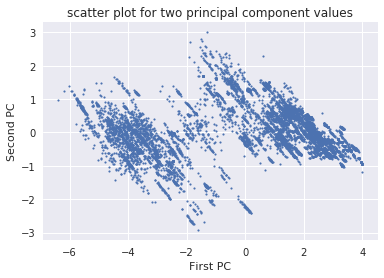

In [40]:
# 2-d scatter plot with two main principal components as axes using all 20 imputed sets

fig = plt.figure()
X, Y = data[:, 0], data[:, 1]

plt.scatter(X, Y, s=3)
plt.title('scatter plot for two principal component values using all 20 imputed sets')
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.show()
plt.close()

# Scatter plot for two principal component values (the first two biggest components). Each data point is colored differently based on which of the two gaussians it belongs to. Red points are in the first Gaussian and blue points are in the second Gaussian, with the second Gaussian having more weight than the first Gaussian

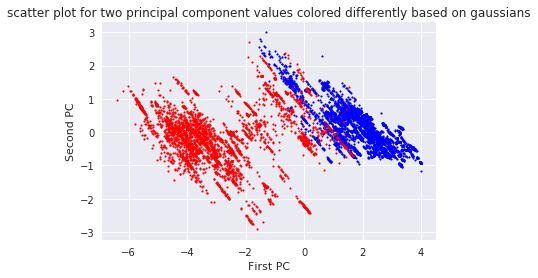

In [7]:
# mark dots differently based on which of the two gaussians they belong

times = pnas_data1.loc[:, ['Time']].values

#fit GMM
gmm = GMM(n_components=2).fit(data)
cov = gmm.covariances_
prob_distr = gmm.predict_proba(data)

# determine to which of the two gaussians each data point belongs by looking at probability distribution 
gauss1_idx = [i for i in range(len(prob_distr)) if prob_distr[i][0] >= prob_distr[i][1]]
gauss2_idx = [j for j in range(len(prob_distr)) if prob_distr[j][1] >= prob_distr[j][0]]

gauss1_time = [times[i] for i in gauss1_idx] # time for the first gaussian data
gauss2_time = [times[j] for j in gauss2_idx] # time for the second gaussian data

gauss1_pc1 = [data[:,0][i] for i in gauss1_idx] # first pc values for the first gaussian
gauss2_pc1 = [data[:,0][j] for j in gauss2_idx] # first pc values for the second gaussian

gauss1_pc2 = [data[:,1][i] for i in gauss1_idx]
gauss2_pc2 = [data[:,1][j] for j in gauss2_idx]

plt.scatter(gauss1_pc1, gauss1_pc2, s=3, c='b')
plt.scatter(gauss2_pc1, gauss2_pc2, s=3, c='r')

plt.title('scatter plot for two principal component values colored differently based on gaussians')
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.show()
plt.close()

# For the scatter plot of two main principal component values, mark data points within each Gaussian with different color gradation based on time (lighter the color, the earlier society it is) 

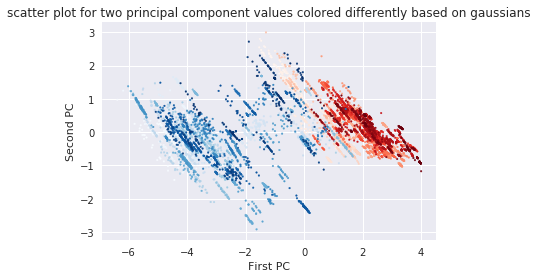

In [8]:
# mark different colors based on time (lighter the color, the earlier societies it is) for each Gaussian

# sort gauss1_pc1, gauss1_pc2, gauss2_pc1, gauss2_pc2 based on their respective time periods

gauss1_idx_time = sorted(range(len(gauss1_pc1)), key = lambda i: gauss1_time[i])
gauss2_idx_time = sorted(range(len(gauss2_pc1)), key = lambda i: gauss2_time[i])

sorted_gauss1_pc1 = [gauss1_pc1[idx] for idx in gauss1_idx_time]
sorted_gauss1_pc2 = [gauss1_pc2[idx] for idx in gauss1_idx_time]
sorted_gauss2_pc1 = [gauss2_pc1[idx] for idx in gauss2_idx_time]
sorted_gauss2_pc2 = [gauss2_pc2[idx] for idx in gauss2_idx_time]

plt.scatter(sorted_gauss1_pc1, sorted_gauss1_pc2, s=3, c=range(len(sorted_gauss1_pc1)), cmap = 'Reds')
plt.scatter(sorted_gauss2_pc1, sorted_gauss2_pc2, s=3, c=range(len(sorted_gauss2_pc1)), cmap = 'Blues')

plt.title('scatter plot for two principal component values colored differently based on gaussians')
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.show()
plt.close()

['Big Island Hawaii', 'Cahokia', 'Cambodian Basin', 'Central Java', 'Chuuk Islands', 'Cuzco', 'Deccan', 'Finger Lakes', 'Garo Hills', 'Ghanaian Coast', 'Iceland', 'Kachi Plain', 'Kansai', 'Kapuasi Basin', 'Konya Plain', 'Latium', 'Lena River Valley', 'Lowland Andes', 'Middle Yellow River Valley', 'Niger Inland Delta', 'North Colombia', 'Orkhon Valley', 'Oro PNG', 'Paris Basin', 'Sogdiana', 'Southern China Hills', 'Susiana', 'Upper Egypt', 'Valley of Oaxaca', 'Yemeni Coastal Plain']


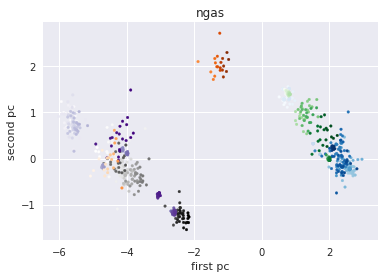

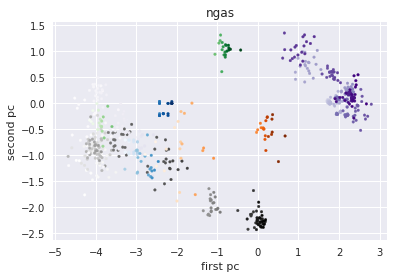

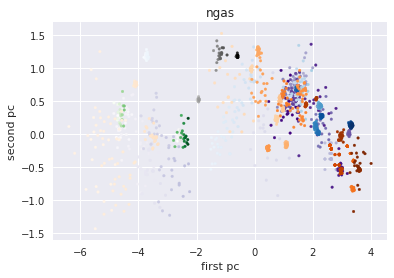

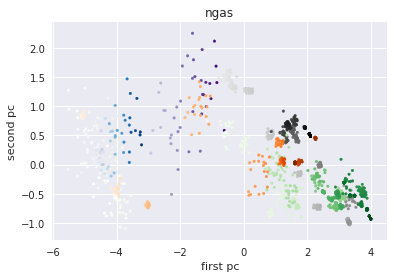

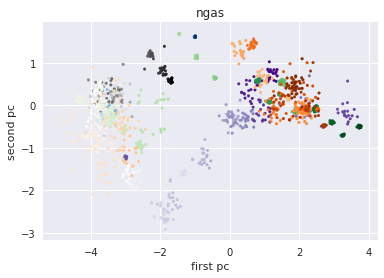

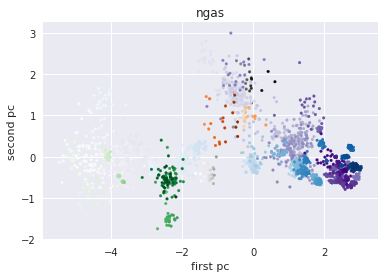

In [19]:
# Same scatter plot as above. Mark different NGAs with different colors 

nga_dict = {key:list() for key in ngas}

for idx in range(len(data)):
    nga = pnas_data1.loc[idx].NGA
    nga_dict[nga].append((data[:,0][idx], data[:,1][idx], times[idx][0]))            

cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'PuRd', 'BuPu', 'GnBu']

for i in range(6):
    nga_split = ngas[5*i:5*i+5]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(nga_split))))

    for i in range(len(nga_split)):
        nga_pc1 = [i for i,_,_ in nga_dict[nga_split[i]]]
        nga_pc2 = [j for _,j,_ in nga_dict[nga_split[i]]]
        nga_time = [k for _,_,k in nga_dict[nga_split[i]]]

        nga_pc1 = [x for _,x,_ in sorted(zip(nga_time, nga_pc1, nga_pc2))]
        nga_pc2 = [y for _,_,y in sorted(zip(nga_time, nga_pc1, nga_pc2))]

        assert len(nga_pc1) == len(nga_pc2)

        plt.scatter(nga_pc1, nga_pc2, s=7, c=range(len(nga_pc1)), cmap = cmaps[i])

    plt.title('ngas')
    plt.xlabel('first pc')
    plt.ylabel('second pc')
    plt.show()
    plt.close()



# Since the above plot was obtained by using all 20 imputed sets, some of the streaks were presumably the artifacts of imputation. For the plot below, I used a single, randomly selected imputed set (for each row of the data matrix, I randomly selected from one of the 20 imputed sets). Although it's much less visible, you can roughly see the two clusters in the below plot. 

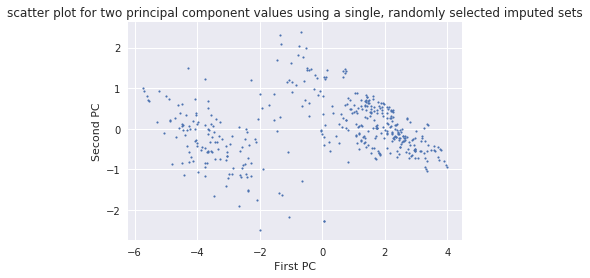

In [53]:
# 2-d scatter plot with two main principal components as axes using a single random imputed set
# each entry of the data matrix was randomly chosen among the 20 imputed sets
single_impute = list()

for i in range(414):
    j = np.random.randint(0, 20)
    single_impute.append(data[i+414*j])
    
assert len(single_impute) == 414 #check if the matrix contains all of the 414 rows 

single_impute = np.asarray(single_impute)
X, Y = single_impute[:, 0], single_impute[:, 1]

plt.scatter(X, Y, s=3)
plt.title('scatter plot for two principal component values using a single, randomly selected imputed sets')
plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.show()
plt.close()

In [83]:
print(type(pnas_data1.loc[1].NGA))

<class 'str'>
